In [28]:
# Packages
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
%matplotlib inline

In [29]:
# Options
sns.set_style("whitegrid")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', -1)

In [30]:
explore_in = './data/transformed_data/explore.csv'
train_in = './data/transformed_data/model_train_linear.csv'
test_in = './data/transformed_data/model_test_linear.csv'
model_out = './data/transformed_data/linear_models.csv'

In [31]:
drop_vars = [
    'Id', 'Neighborhood', 'MSZoning', 'BldgType', 'Functional', 'MSSubClass', 
    'Condition1', 'LotConfig', 'MasVnrType', 'SaleType', 'SaleCondition', 'Stories',
]
keep_vars = [
    'GarageCars', 'OverallQual', 'Neighborhood_ordinal', 'MSSubClass_ordinal', 'TotalBath', 'GrLivArea'
]

#### Train Data

In [32]:
df_train_in = pd.read_csv(train_in)
feature_list = df_train_in.columns.tolist()
target = df_train_in['SalePrice']
features = df_train_in.drop(drop_vars, axis=1)
features.drop('SalePrice', axis=1, inplace=True)
features.head()

,OverallQual,PropertyAge,OverallGrade,ExterGrade,CoreArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotalArea,LotArea,FullBath,HalfBath,TotalBath,TotRmsAbvGrd,BedroomAbvGr,KitchenAbvGr,SimpleOverallQual,SimpleOverallCond,Neighborhood_ordinal,MSSubClass_ordinal,GarageCars,IsRemodelled,IsNew,IsCulDeSac,IsPartial,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Stories_1,Stories_1.5Unf,Stories_2,Stories_S
0,0.510826,0.036105,0.323548,0.342945,0.312078,0.236651,0.165831,0.385090,0.349146,0.337489,0.032874,0.405465,0.223144,0.405465,0.405465,0.318454,0.287682,0.510826,0.405465,0.666667,1.000000,0.666667,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.441833,0.205339,0.424019,0.241162,0.307021,0.331917,0.278134,0.000000,0.248273,0.297811,0.038061,0.287682,0.223144,0.262364,0.287682,0.318454,0.287682,0.287682,0.693147,0.791667,0.714286,0.666667,1,0,0,0,0,0,0,0,1,0,1,0,0,0
2,0.510826,0.050190,0.323548,0.342945,0.328753,0.252284,0.184393,0.389571,0.365292,0.354492,0.045458,0.405465,0.223144,0.405465,0.287682,0.318454,0.287682,0.510826,0.405465,0.666667,1.000000,0.666667,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0.510826,0.512295,0.323548,0.241162,0.300846,0.211725,0.196105,0.347724,0.350644,0.330638,0.037836,0.287682,0.000000,0.182322,0.348307,0.318454,0.287682,0.510826,0.405465,0.750000,0.642857,1.000000,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0.575364,0.057158,0.363394,0.342945,0.401299,0.305382,0.247044,0.456923,0.448556,0.433189,0.058812,0.405465,0.223144,0.405465,0.459532,0.405465,0.287682,0.510826,0.405465,0.958333,1.000000,1.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0


#### Test Data

In [33]:
df_test_in = pd.read_csv('./data/transformed_data/model_test_linear.csv')
test_features = df_test_in.drop(drop_vars, axis=1)
test_features.head()

,OverallQual,PropertyAge,OverallGrade,ExterGrade,CoreArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotalArea,LotArea,FullBath,HalfBath,TotalBath,TotRmsAbvGrd,BedroomAbvGr,KitchenAbvGr,SimpleOverallQual,SimpleOverallCond,Neighborhood_ordinal,MSSubClass_ordinal,GarageCars,Foundation,IsRemodelled,IsNew,IsCulDeSac,IsPartial,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Stories_1,Stories_1.5Unf,Stories_2,Stories_S,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc
0,0.367725,0.325422,0.336472,0.265703,0.114879,0.159659,0.099220,0.000000,0.099220,0.098318,0.169022,0.000000,0.000000,0.000000,0.154151,0.287682,0.405465,0.287682,0.405465,0.318454,0.064958,0.287682,CBlock,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
1,0.441833,0.341952,0.395896,0.265703,0.193603,0.231781,0.179545,0.000000,0.179545,0.179545,0.208740,0.000000,0.405465,0.080043,0.223144,0.405465,0.405465,0.287682,0.405465,0.318454,0.064958,0.287682,CBlock,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2,0.367725,0.102279,0.284104,0.265703,0.184876,0.167326,0.105382,0.319527,0.231640,0.191299,0.202285,0.182322,0.405465,0.223144,0.223144,0.405465,0.405465,0.287682,0.405465,0.432864,0.089804,0.510826,PConc,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,0.441833,0.095310,0.395896,0.265703,0.182530,0.166994,0.104998,0.310513,0.227401,0.188241,0.143517,0.182322,0.405465,0.223144,0.287682,0.405465,0.405465,0.287682,0.405465,0.432864,0.089804,0.510826,PConc,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,0.575364,0.136412,0.433636,0.361013,0.185137,0.224124,0.170772,0.000000,0.170772,0.170772,0.062149,0.182322,0.000000,0.154151,0.154151,0.287682,0.405465,0.510826,0.405465,0.650588,0.083650,0.510826,PConc,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1


#### Ridge

In [37]:
scoring = make_scorer(mean_squared_error)
alphas = [0.01, 0.03, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 5, 10, 50]
ridge = RidgeCV(alphas=alphas)
ridge.fit(features, target)
ridge_score = np.mean(np.sqrt(cross_val_score(ridge, features, target, cv=20, scoring=scoring)))
ridge_score

0.12433558615440328

#### Ridge Coefficients

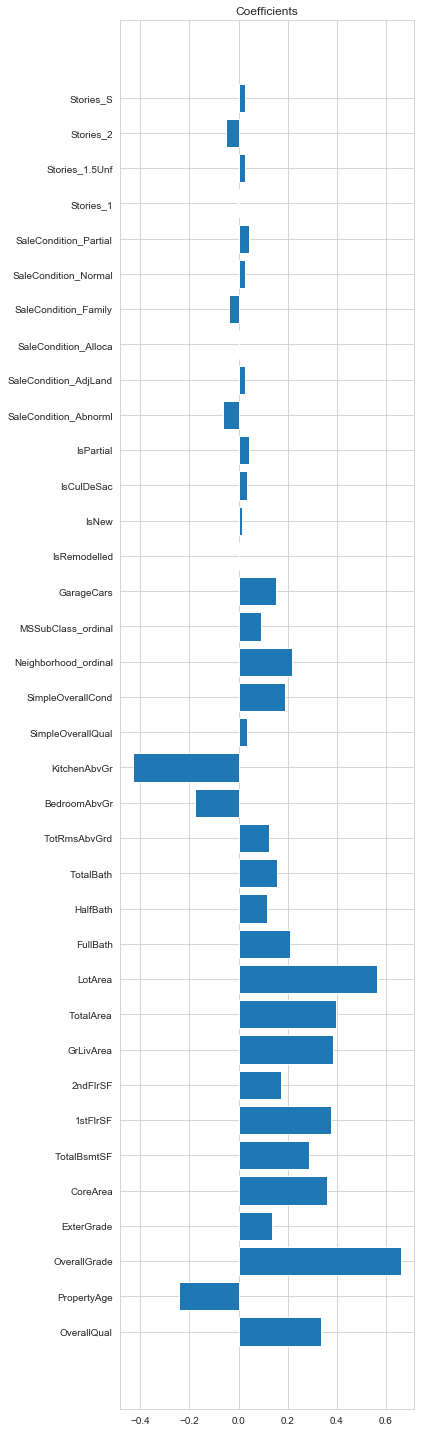

In [38]:
coefs = ridge.coef_
plt.figure(figsize=(6, 20))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), features)
plt.title("Coefficients")
plt.tight_layout()

#### Ridge Submission

In [27]:
predictions = ridge.predict(test_features)
df_sub = pd.DataFrame()
df_sub['Id'] = df_test_in['Id']
df_sub['SalePrice'] = np.expm1(ridge.predict(test_features))
df_sub.to_csv('./data/output_data/ridge_submission.csv', index=False)

#### Lasso

In [40]:
scoring = make_scorer(mean_squared_error)
alphas = [0.01, 0.03, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 5, 10, 50]
lasso = LassoCV(alphas=alphas)
lasso.fit(features, target)
lasso_score = np.mean(np.sqrt(cross_val_score(lasso, features, target, cv=20, scoring=scoring)))
lasso_score

0.19454603837982595

#### Lasso Coefficients

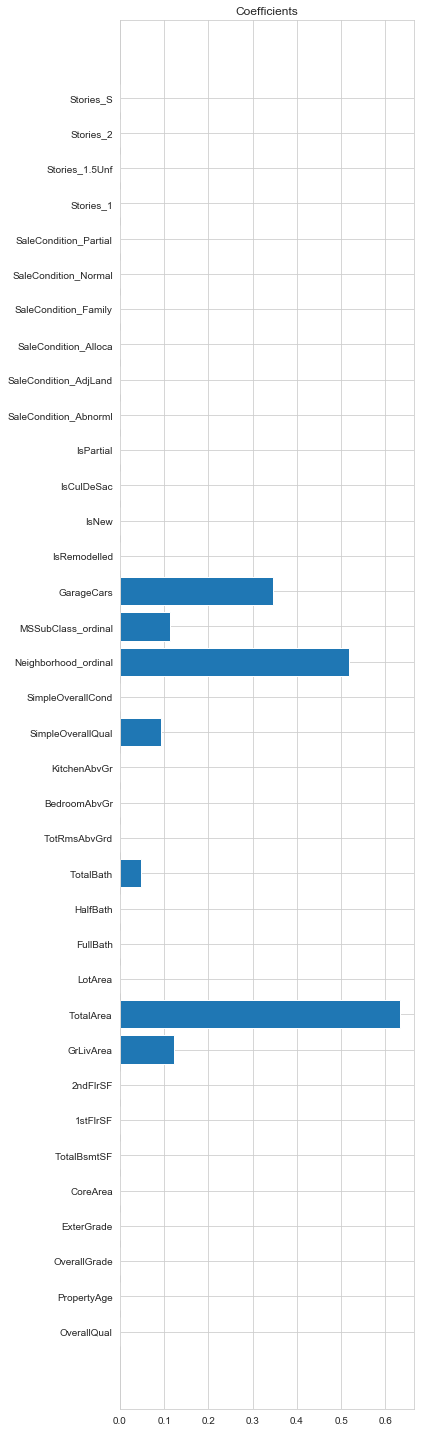

In [42]:
coefs = lasso.coef_
plt.figure(figsize=(6, 20))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), features)
plt.title("Coefficients")
plt.tight_layout()

#### ElasticNet

In [47]:
scoring = make_scorer(mean_squared_error)
l1_ratio=0.5,
alphas=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 10],
elastic = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, max_iter=5000)
elastic.fit(features, target)
elastic_score = np.mean(np.sqrt(cross_val_score(elastic, features, target, cv=20, scoring=scoring)))
elastic_score

0.39450991611931163

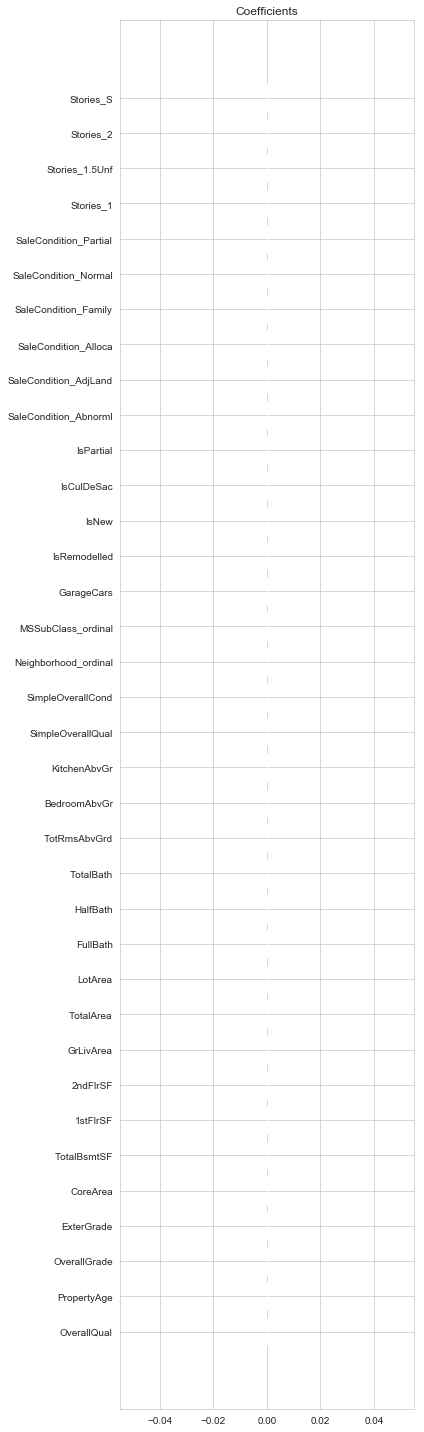

In [48]:
coefs = elastic.coef_
plt.figure(figsize=(6, 20))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), features)
plt.title("Coefficients")
plt.tight_layout()